# **DATA ANALYSIS AND VISUALIZATION**

In [ ]:
! pip install wordcloud
! pip install nltk

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns


import re
from transformers import AutoTokenizer
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW, BertForSequenceClassification, BertTokenizer,  DistilBertTokenizer, DistilBertForSequenceClassification, RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from torch.nn.functional import softmax

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from wordcloud import WordCloud

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **small data(645 newspapers)**

In [3]:
# PATH = '/kaggle/input/articles/Data/Task 1/Media 645 (1)'
# PATH = 'C://Users//user//Desktop//Data//Task 1//Media 2728 (2)'
PATH = 'C://Users//user//Desktop//Data//Task 1//Media 645 (1)'

if os.path.exists(PATH):
    print("file exists")
else:
    print("file not exists")

#List of files from each news agency
json_files = [f for f in os.listdir(PATH) if f.endswith('.json')]
json_files = shuffle(json_files, random_state=42)
all_data = pd.DataFrame()
#We take the required number _ of files
n_json_files = json_files[:100]


file exists


We need to take the necessary amount of data and present it in the form of a dataframe to make it convenient for processing

In [4]:
%%time
def process_json_file(json_file):
    df = pd.read_json(os.path.join(PATH, json_file))
    if 'articles' in df.columns:
        articles_df = df['articles'].apply(pd.Series)
        df = df.drop('articles', axis=1)
        df = pd.concat([df, articles_df], axis=1)
    d = {'leftcenter': 'left-center', 'rightcenter': 'right-center'}
    df['bias'] = df['bias'].replace(d)
    return df


data_frames = []
for json_file in tqdm(n_json_files):
    df = process_json_file(json_file)
    data_frames.append(df)
all_data = pd.DataFrame()
all_data = pd.concat(data_frames, ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'text', 'id']]
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

100%|██████████| 100/100 [00:11<00:00,  8.44it/s]

The data has been successfully loaded.
Size: (28383, 5)
CPU times: total: 11.2 s
Wall time: 11.9 s


Now the data represents thousands of rows where each row contains information about the article and its text.

In [5]:
all_data.head()

name   fact  bias                                               text  \
0  Uproxx  mixed  left  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
1  Uproxx  mixed  left  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
2  Uproxx  mixed  left  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
3  Uproxx  mixed  left  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
4  Uproxx  mixed  left  UPROXX MusicAll Things Hip-Hop And New MusicUP...   

         id  
0  439ad982  
1  433305dd  
2  aace149b  
3  537f654d  
4  020243e2

In [6]:
print('number of newspapers:', len(all_data['name'].unique()))
print('number of articles:', all_data.shape[0])
print('--------bias-------------------')
print(all_data['bias'].value_counts())
print('--------fact-------------------')
print(all_data['fact'].value_counts())
all_data.describe()
print('-------------------------------')


number of newspapers: 100
number of articles: 28383
--------bias-------------------
bias
right           17200
left             5946
center           4956
left-center       179
right-center      102
Name: count, dtype: int64
--------fact-------------------
fact
mixed             11184
high              10880
low                5944
mostly factual      373
very low              2
Name: count, dtype: int64
-------------------------------


## visualisation

Let's look at the distribution of credibility and sentiment for all articles

To roughly estimate is there the class imbalance, we split the text by spaces and hyphens and calculate the number of words for each article.

In [7]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact']

In [8]:
#add column with sum of words for each text
all_data['text'] = all_data['text'].astype(str)
all_data['num_words'] = all_data['text'].apply(lambda x: len(x.split() + x.split('-')))

Let's create several plots for dataset analysis.

Here's an interesting point: it's evident that the number of words per article for each class roughly matches, but the actual number of articles varies significantly - this affects the size of the sample for training. In the future, this will impact the ability to use various metrics, which will be discussed further

C:\Users\user\AppData\Local\Temp\ipykernel_14300\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


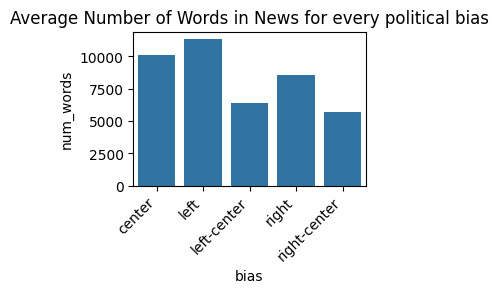

C:\Users\user\AppData\Local\Temp\ipykernel_14300\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


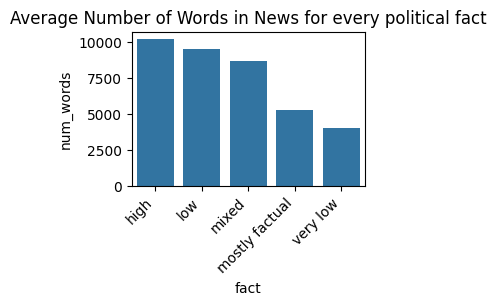

In [9]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].mean().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Average Number of Words in News for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()



C:\Users\user\AppData\Local\Temp\ipykernel_14300\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


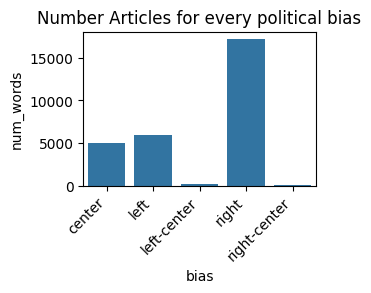

C:\Users\user\AppData\Local\Temp\ipykernel_14300\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


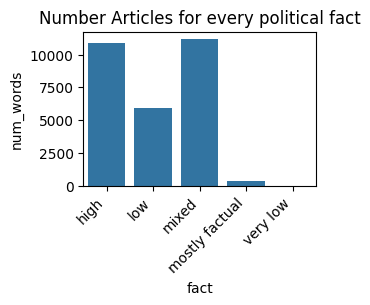

In [10]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS).count().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Number Articles for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_14300\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


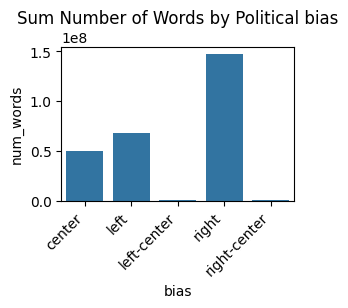

C:\Users\user\AppData\Local\Temp\ipykernel_14300\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


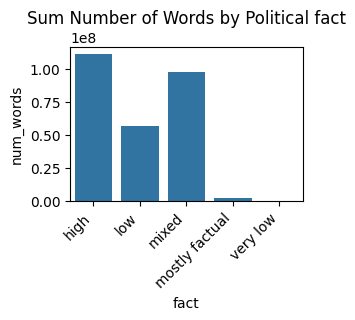

In [11]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Sum Number of Words by Political {COLUMN_FOR_ANALYSIS}')
    plt.show()


Grouping and counting the total number of words in each category.

In [12]:
sum_words = all_data.groupby('bias')['num_words'].sum()
total_words = sum_words.sum()
proportions = sum_words / total_words
print(proportions)
print('------------------------------------')
sum_words_f = all_data.groupby('fact')['num_words'].sum()
total_words_f = sum_words_f.sum()
proportions_f = sum_words_f / total_words_f
print(proportions_f)


bias
center          0.187890
left            0.253116
left-center     0.004301
right           0.552505
right-center    0.002187
Name: num_words, dtype: float64
------------------------------------
fact
high              0.416404
low               0.211377
mixed             0.364780
mostly factual    0.007409
very low          0.000030
Name: num_words, dtype: float64


**It's evident that the total number of articles and words doesn't match, indicating class imbalance**

In [13]:
all_data['bias_fact'] = list(zip(all_data['bias'], all_data['fact']))
all_data['bias_fact'].unique()

array([(0, 2), (4, 1), (4, 2), (2, 4), (1, 4), (0, 4), (0, 3), (4, 3),
       (4, 4), (3, 2), (0, 1), (1, 2), (3, 4), (4, 0)], dtype=object)

In [14]:
all_data.head()

name  fact  bias                                               text  \
0  Uproxx     2     0  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
1  Uproxx     2     0  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
2  Uproxx     2     0  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
3  Uproxx     2     0  UPROXX MusicAll Things Hip-Hop And New MusicUP...   
4  Uproxx     2     0  UPROXX MusicAll Things Hip-Hop And New MusicUP...   

         id  num_words bias_fact  
0  439ad982       3705    (0, 2)  
1  433305dd      49029    (0, 2)  
2  aace149b      15352    (0, 2)  
3  537f654d      15352    (0, 2)  
4  020243e2       3835    (0, 2)

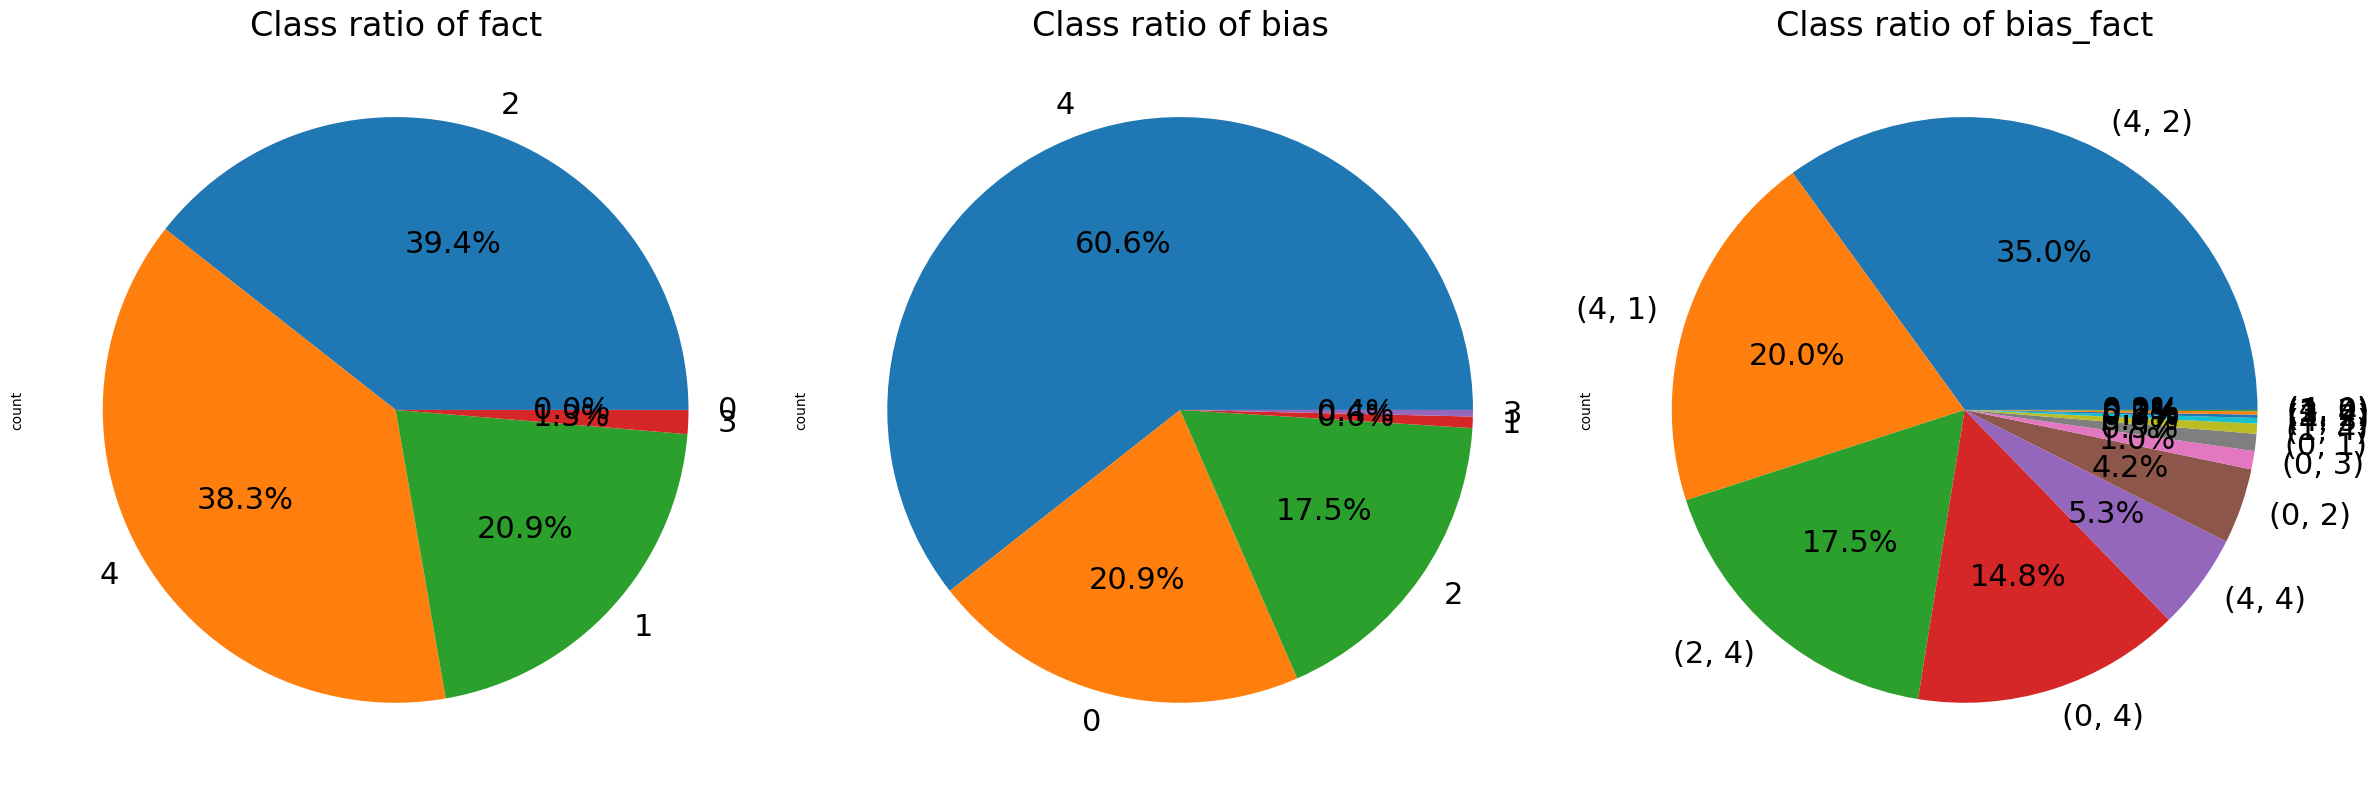

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# График 1
all_data['fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[0], textprops={'fontsize': 14}) 
ax[0].set_title('Class ratio of fact', fontsize=24)

# График 2
all_data['bias'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1], textprops={'fontsize': 14}) 
ax[1].set_title('Class ratio of bias', fontsize=24)

# График 3
all_data['bias_fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[2],  textprops={'fontsize': 14}) 
ax[2].set_title('Class ratio of bias_fact', fontsize=24)

plt.tight_layout() 
plt.show()

In [ ]:
def generate_wordcloud_for_label(df, label):
    plt.figure(figsize=(12, 8))
    
    # Фильтруем DataFrame по указанной метке
    subset = df[df['bias'] == label]
    
    # Генерируем облако слов из предложений, соответствующих фильтру
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(subset['text']))
    
    # Визуализация облака слов
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word cloud for class {label}')
    plt.show()
unique_labels = all_data['bias'].unique()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def clean_text_vectorized(text_series):
    text_lower = text_series.str.lower()
    
    text_no_urls = text_lower.str.replace(r'http\S+|www\.\S+', '', regex=True)
    
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    
    text_no_digits = text_no_html.str.replace(r'\d+', '', regex=True)
    
    def remove_stopwords_and_stemming(text):
        words = text.split()
        filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
        return ' '.join(filtered_words)

    cleaned_text = text_no_digits.apply(remove_stopwords_and_stemming)

    return cleaned_text



In [ ]:
all_data['text'] = clean_text_vectorized(all_data['text'])

In [ ]:
def plot_word_distribution(df, label, n=10):
    subset = df[df['bias'] == label]
    
    words = ' '.join(subset['text']).split()
    
    word_count = Counter(words)
    
    common_words = word_count.most_common(n)
    
    words = [item[0] for item in common_words]
    counts = [item[1] for item in common_words]
    plt.figure(figsize=(10, 8))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title(f'Word Distribution for class {label}')
    plt.show()



In [ ]:
unique_labels

In [ ]:
plot_word_distribution(all_data, unique_labels[0], 10)
plot_word_distribution(all_data, unique_labels[1], 10)
plot_word_distribution(all_data, unique_labels[2], 10)
plot_word_distribution(all_data, unique_labels[3], 10)
plot_word_distribution(all_data, unique_labels[4], 10)

In [ ]:
generate_wordcloud_for_label(all_data, unique_labels[0])
generate_wordcloud_for_label(all_data, unique_labels[1])
generate_wordcloud_for_label(all_data, unique_labels[2])
generate_wordcloud_for_label(all_data, unique_labels[3])
generate_wordcloud_for_label(all_data, unique_labels[4])

# **big data(2045 newspapers)**

In [73]:
# PATH = '/kaggle/input/articles/Data/Task 1/Media 645 (1)'
PATH = 'C://Users//user//Desktop//Data//Task 1//Media 2728 (2)'
# PATH = 'C://Users//user//Desktop//Data//Task 1//Media 645 (1)'

if os.path.exists(PATH):
    print("file exists")
else:
    print("file not exists")

#List of files from each news agency
json_files = [f for f in os.listdir(PATH) if f.endswith('.json')]
json_files = shuffle(json_files, random_state=42)
all_data = pd.DataFrame()
#We take the required number _ of files
n_json_files = json_files[:100]

file exists


In [74]:
%%time
def process_json_file(json_file):
    df = pd.read_json(os.path.join(PATH, json_file))
    if 'articles' in df.columns:
        articles_df = df['articles'].apply(pd.Series)
        df = df.drop('articles', axis=1)
        df = pd.concat([df, articles_df], axis=1)
    d = {'leftcenter': 'left-center', 'rightcenter': 'right-center'}
    df['bias'] = df['bias'].replace(d)
    return df


data_frames = []
for json_file in tqdm(n_json_files):
    df = process_json_file(json_file)
    data_frames.append(df)
all_data = pd.DataFrame()
all_data = pd.concat(data_frames, ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'text', 'id']]
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

  5%|▌         | 5/100 [00:00<00:02, 42.34it/s]

100%|██████████| 100/100 [00:02<00:00, 43.44it/s]

The data has been successfully loaded.
Size: (3168, 5)
CPU times: total: 2.11 s
Wall time: 2.31 s


In [75]:
print('number of newspapers:', len(all_data['name'].unique()))
print('number of articles:', all_data.shape[0])
print('--------bias-------------------')
print(all_data['bias'].value_counts())
print('--------fact-------------------')
print(all_data['fact'].value_counts())
all_data.describe()
print('-------------------------------')


number of newspapers: 100
number of articles: 3168
--------bias-------------------
bias
center          1069
right-center     987
right            465
left-center      345
left             302
Name: count, dtype: int64
--------fact-------------------
fact
high              1648
mixed             1115
mostly factual     228
low                128
very high           33
very low            16
Name: count, dtype: int64


-------------------------------


In [76]:
#add column with sum of words for each text
all_data['text'] = all_data['text'].astype(str)
all_data['num_words'] = all_data['text'].apply(lambda x: len(x.split() + x.split('-')))

C:\Users\user\AppData\Local\Temp\ipykernel_14300\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


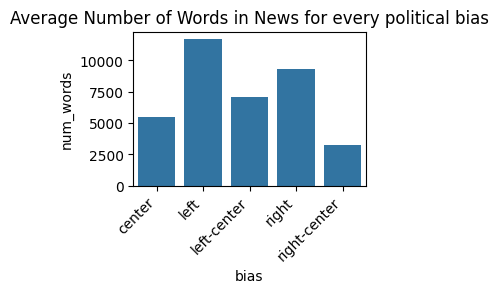

C:\Users\user\AppData\Local\Temp\ipykernel_14300\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


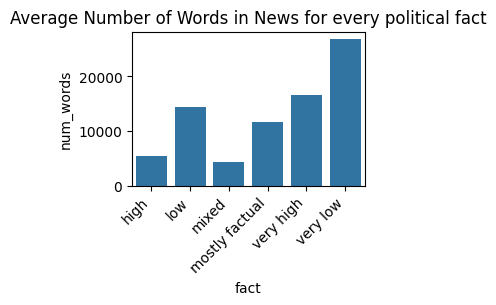

In [77]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].mean().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Average Number of Words in News for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()



C:\Users\user\AppData\Local\Temp\ipykernel_14300\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


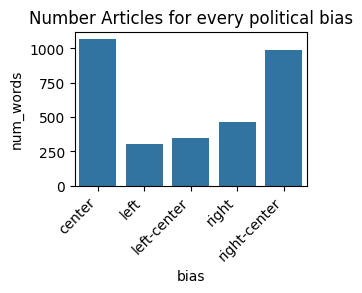

C:\Users\user\AppData\Local\Temp\ipykernel_14300\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


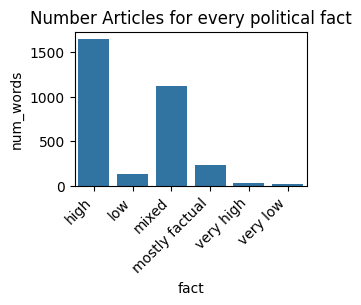

In [41]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS).count().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Number Articles for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_14300\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


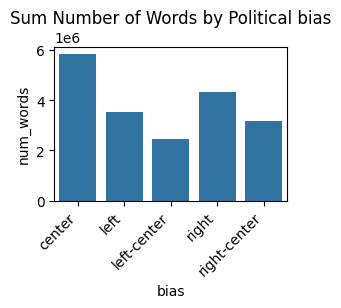

C:\Users\user\AppData\Local\Temp\ipykernel_14300\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


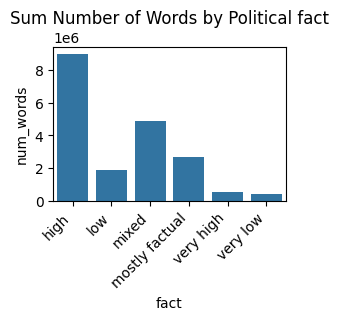

In [42]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Sum Number of Words by Political {COLUMN_FOR_ANALYSIS}')
    plt.show()


In [43]:
sum_words = all_data.groupby('bias')['num_words'].sum()
total_words = sum_words.sum()
proportions = sum_words / total_words
print(proportions)
print('------------------------------------')
sum_words_f = all_data.groupby('fact')['num_words'].sum()
total_words_f = sum_words_f.sum()
proportions_f = sum_words_f / total_words_f
print(proportions_f)


bias
center          0.302317
left            0.182990
left-center     0.126695
right           0.223521
right-center    0.164476
Name: num_words, dtype: float64
------------------------------------
fact
high              0.464379
low               0.095811
mixed             0.251771
mostly factual    0.137560
very high         0.028258
very low          0.022221
Name: num_words, dtype: float64


In [78]:
all_data['bias_fact'] = list(zip(all_data['bias'], all_data['fact']))
all_data['bias_fact'].unique()

array([('center', 'high'), ('right-center', 'mixed'),
       ('right-center', 'high'), ('right', 'mixed'), ('left', 'high'),
       ('center', 'very high'), ('left', 'mostly factual'),
       ('right-center', 'mostly factual'), ('center', 'mixed'),
       ('left-center', 'mostly factual'), ('right', 'low'),
       ('left-center', 'high'), ('left-center', 'mixed'),
       ('left', 'mixed'), ('right-center', 'low'), ('right', 'very low')],
      dtype=object)

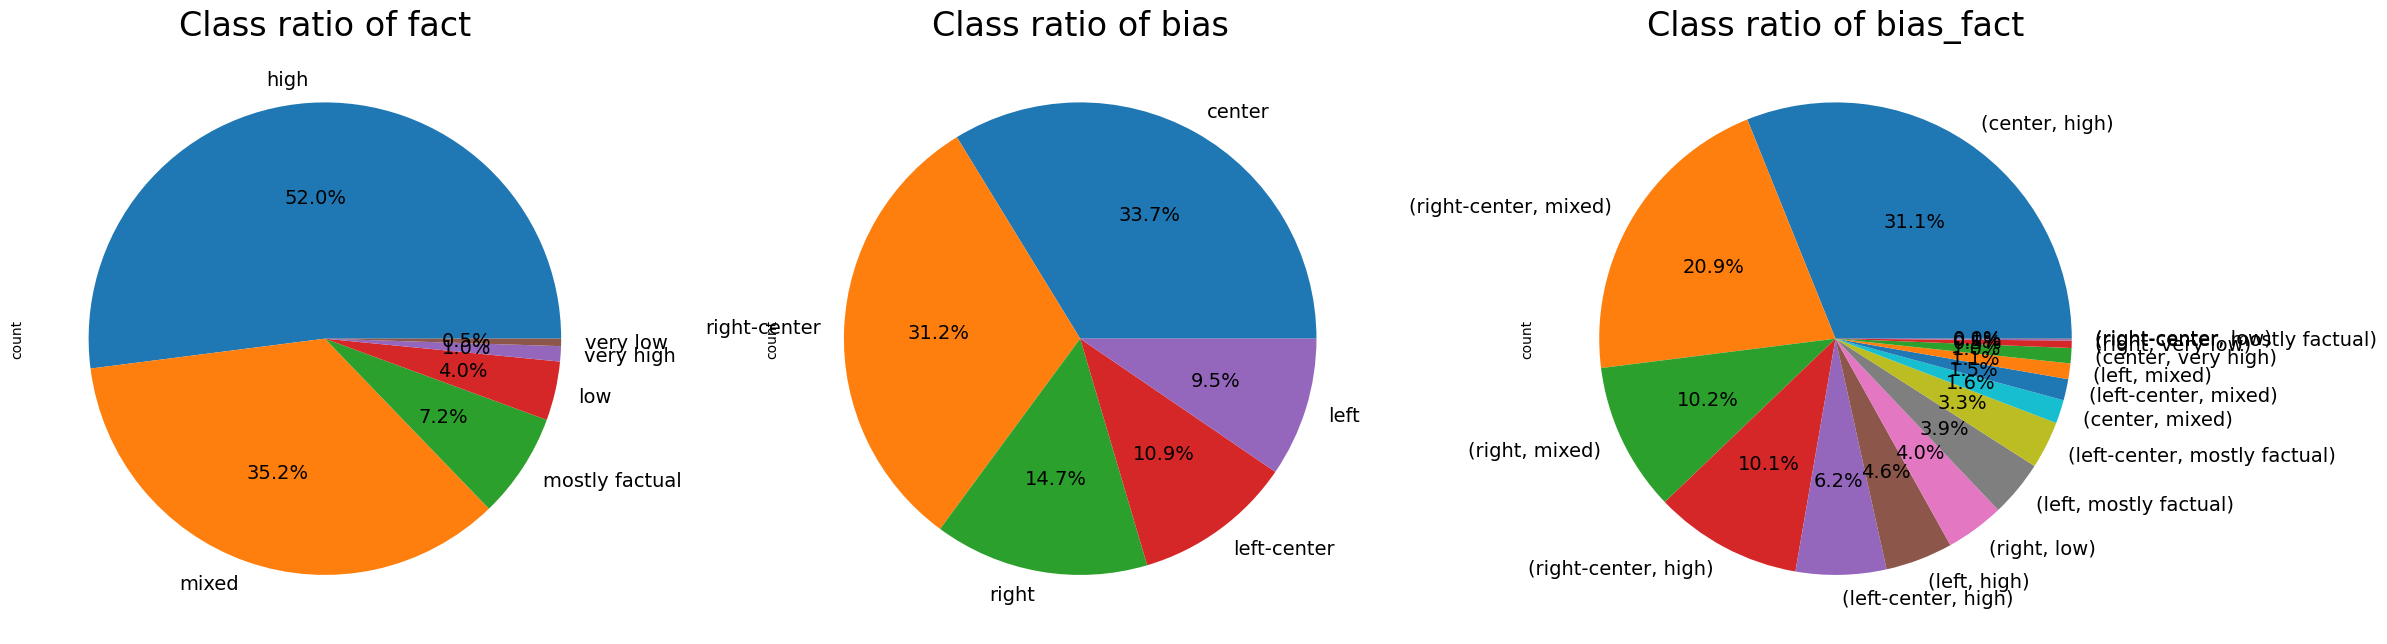

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# График 1
all_data['fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[0], textprops={'fontsize': 14}) 
ax[0].set_title('Class ratio of fact', fontsize=24)

# График 2
all_data['bias'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1], textprops={'fontsize': 14}) 
ax[1].set_title('Class ratio of bias', fontsize=24)

# График 3
all_data['bias_fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[2],  textprops={'fontsize': 14}) 
ax[2].set_title('Class ratio of bias_fact', fontsize=24)

plt.tight_layout() 
plt.show()

In [88]:
! pip install wordcloud
from wordcloud import WordCloud
def generate_wordcloud_for_label(df, label):
    plt.figure(figsize=(12, 8))
    
    # Фильтруем DataFrame по указанной метке
    subset = df[df['bias'] == label]
    
    # Генерируем облако слов из предложений, соответствующих фильтру
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(subset['text']))
    
    # Визуализация облака слов
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word cloud for class {label}')
    plt.show()
unique_labels = all_data['bias'].unique()

In [97]:
! pip install nltk 

Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)


In [98]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def clean_text_vectorized(text_series):
    text_lower = text_series.str.lower()
    
    text_no_urls = text_lower.str.replace(r'http\S+|www\.\S+', '', regex=True)
    
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    
    text_no_digits = text_no_html.str.replace(r'\d+', '', regex=True)
    
    def remove_stopwords_and_stemming(text):
        words = text.split()
        filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
        return ' '.join(filtered_words)

    cleaned_text = text_no_digits.apply(remove_stopwords_and_stemming)

    return cleaned_text




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [100]:
all_data['text'] = clean_text_vectorized(all_data['text'])

In [103]:
def plot_word_distribution(df, label, n=10):
    subset = df[df['bias'] == label]
    
    words = ' '.join(subset['text']).split()
    
    word_count = Counter(words)
    
    common_words = word_count.most_common(n)
    
    words = [item[0] for item in common_words]
    counts = [item[1] for item in common_words]
    plt.figure(figsize=(10, 8))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title(f'Word Distribution for class {label}')
    plt.show()



In [90]:
unique_labels

array(['center', 'right-center', 'right', 'left', 'left-center'],
      dtype=object)

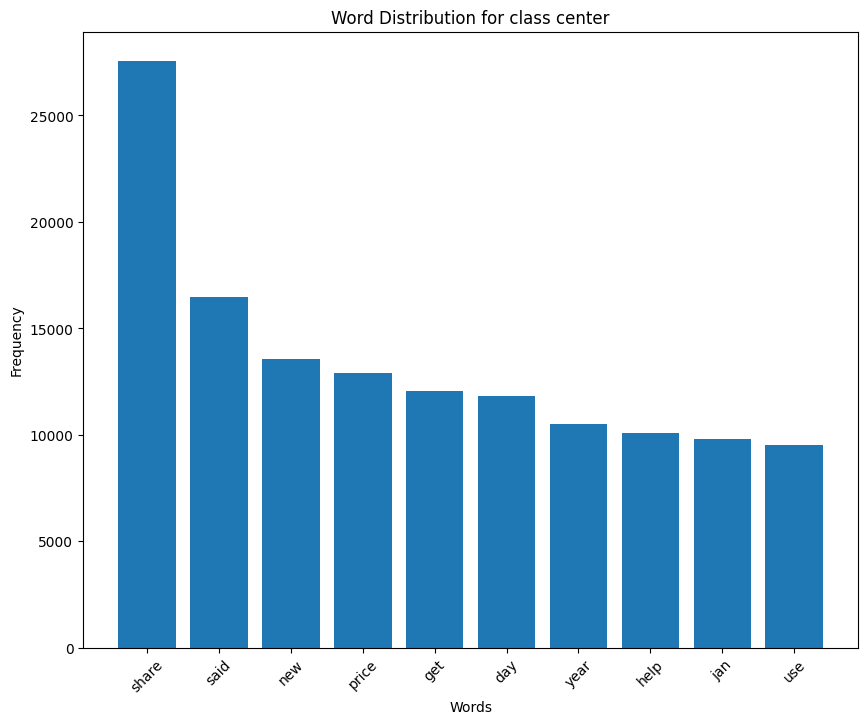

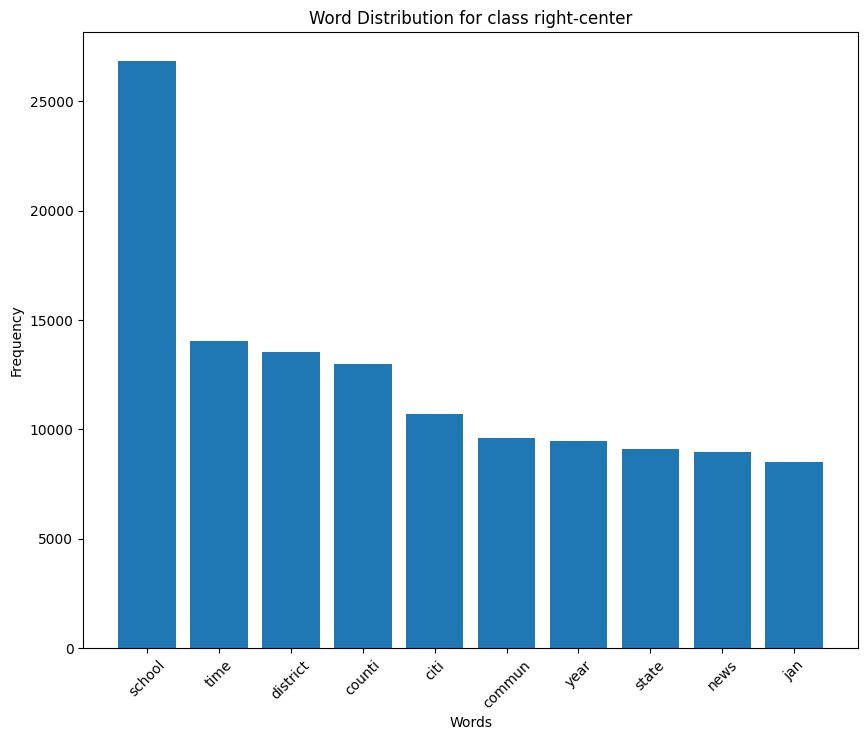

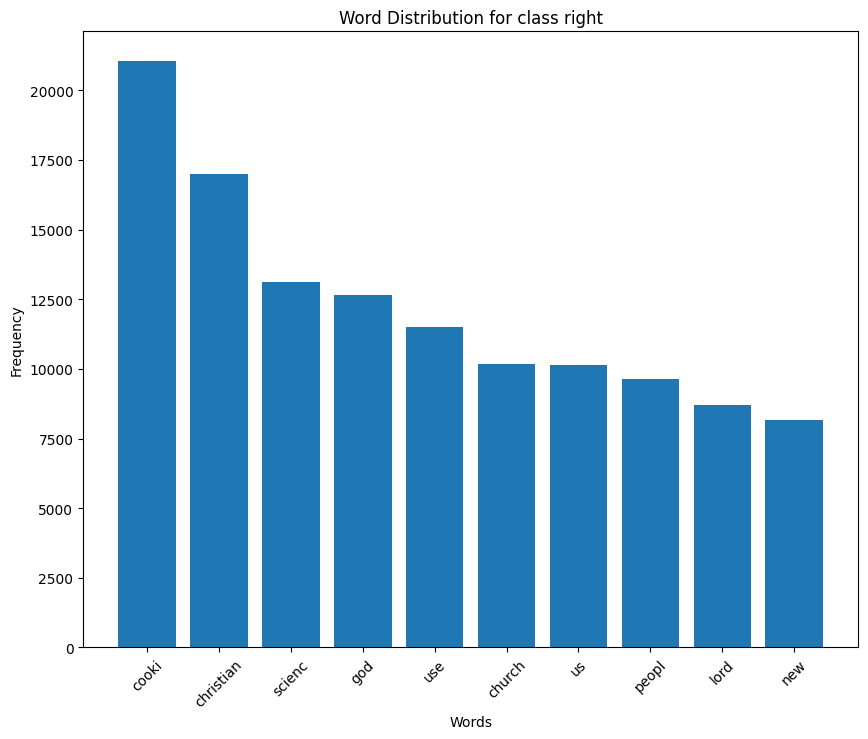

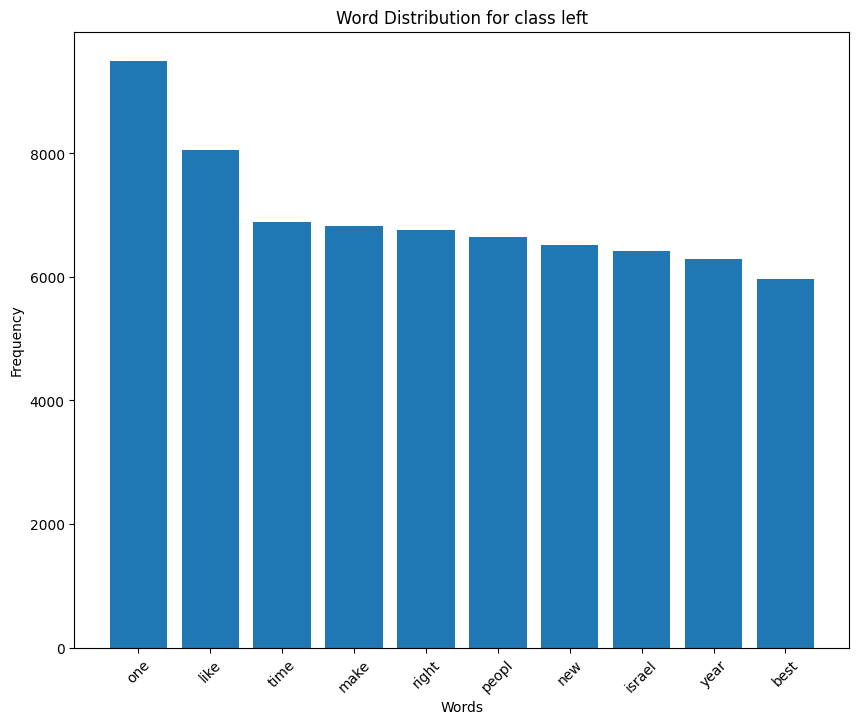

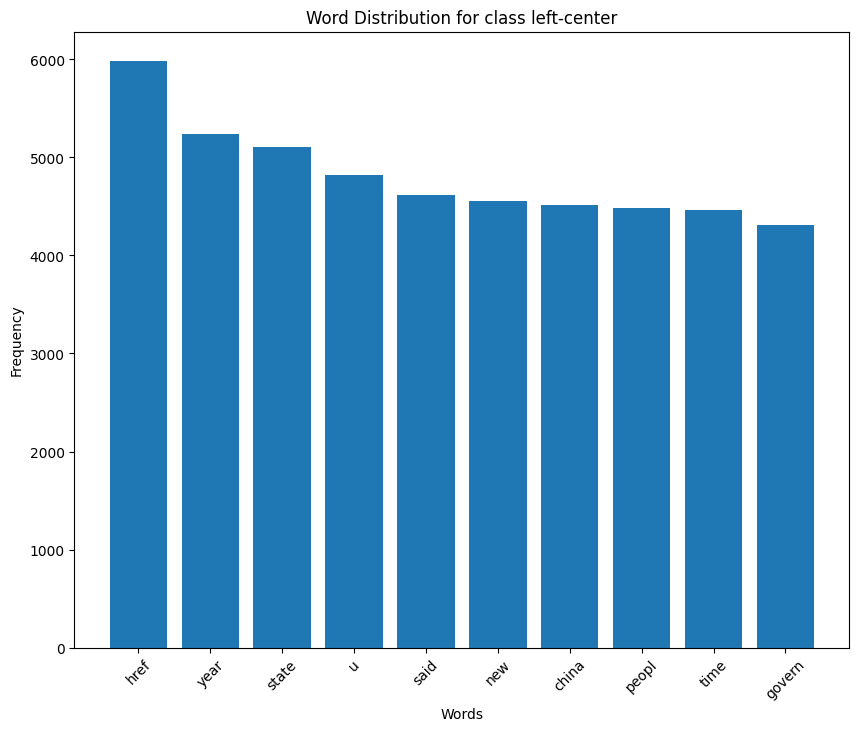

In [105]:
plot_word_distribution(all_data, unique_labels[0], 10)
plot_word_distribution(all_data, unique_labels[1], 10)
plot_word_distribution(all_data, unique_labels[2], 10)
plot_word_distribution(all_data, unique_labels[3], 10)
plot_word_distribution(all_data, unique_labels[4], 10)

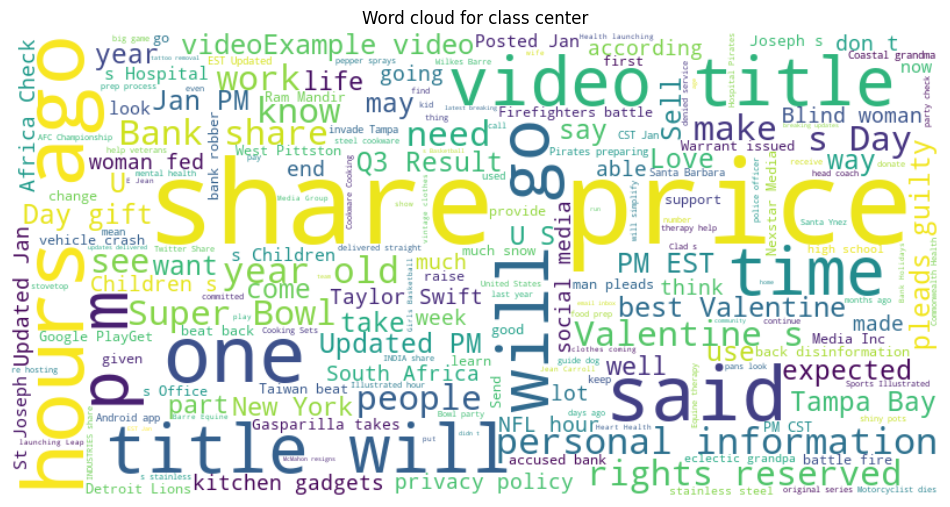

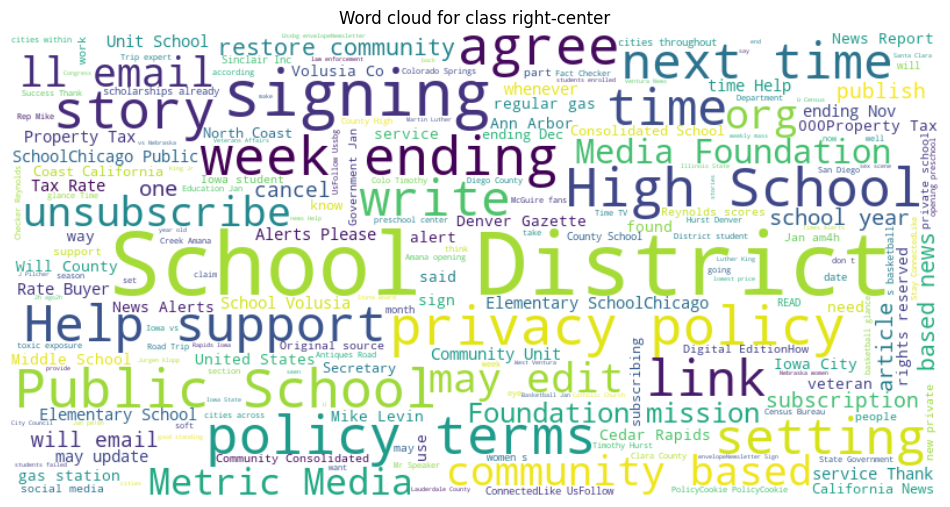

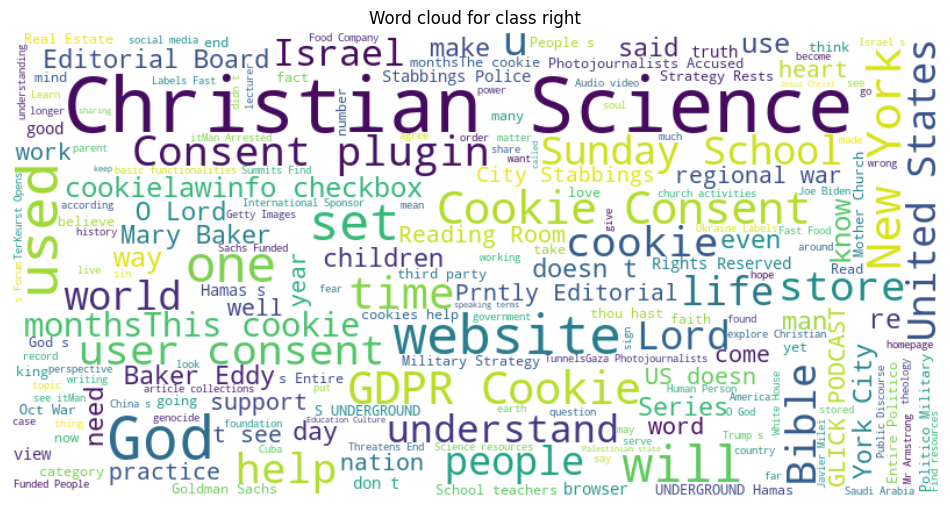

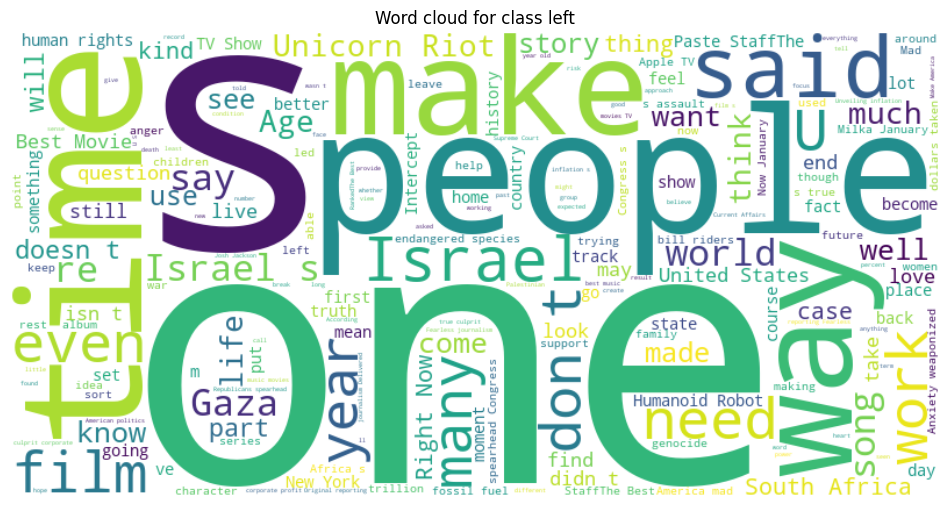

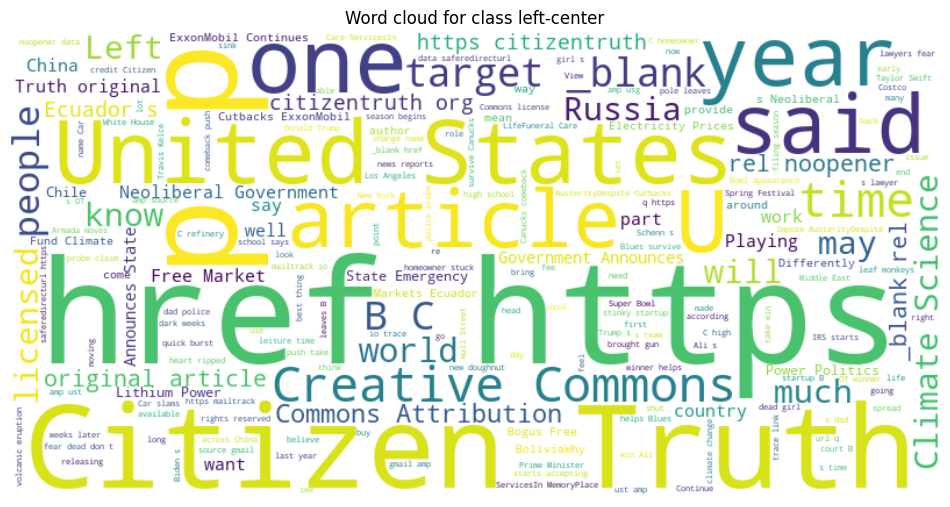

In [91]:
generate_wordcloud_for_label(all_data, unique_labels[0])
generate_wordcloud_for_label(all_data, unique_labels[1])
generate_wordcloud_for_label(all_data, unique_labels[2])
generate_wordcloud_for_label(all_data, unique_labels[3])
generate_wordcloud_for_label(all_data, unique_labels[4])

## **TASK 2**

In [2]:
# PATH = '/kaggle/input/articles/Data/Task 2//'
PATH = 'C://Users//user//Desktop//Data//Task 2//'
if os.path.exists(PATH):
    print("file exists")
else:
    print("file not exists")



file exists


 **---------------------------------------------------------------------------------------------small data(481)----------------------------------------------------------------------------------------------**

We need to take the necessary amount of data and present it in the form of a dataframe to make it convenient for processing

In [3]:
%%time
all_data = pd.DataFrame()
json_file_name = 'wiki (481) (1).json'
# json_file_name = 'wiki (2693) (2).json'
json_file_path = os.path.join(PATH, json_file_name)
df = pd.read_json(json_file_path)
# Unpacking the 'articles' column and removing it
df = df.drop('source_url', axis=1)
# Saving into one dataframe
all_data = pd.concat([all_data, df], ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'wiki']]
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

The data has been successfully loaded.
Size: (481, 4)
CPU times: total: 93.8 ms
Wall time: 123 ms


Now the data represents thousands of rows where each row contains information about the article and its text.

In [4]:
print('number of newspapers:', len(all_data['name'].unique()))
print('number of wiki:', all_data.shape[0])
print('--------bias-------------------')
print(all_data['bias'].value_counts())
print('--------fact-------------------')
print(all_data['fact'].value_counts())
all_data.describe()
print('-------------------------------')


number of newspapers: 480
number of wiki: 481
--------bias-------------------
bias
center    183
left      154
right     144
Name: count, dtype: int64
--------fact-------------------
fact
high     299
mixed    121
low       61
Name: count, dtype: int64
-------------------------------


In [5]:
all_data['bias_fact'] = all_data['bias'] + '-' + all_data['fact']

In [6]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact', 'bias_fact']

In [7]:
#add column with sum of words for each text
all_data['text'] = all_data['wiki'].astype(str)
all_data['num_words'] = all_data['wiki'].apply(lambda x: len(x.split() + x.split('-')))


C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


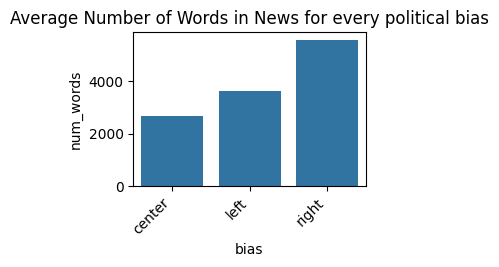

C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


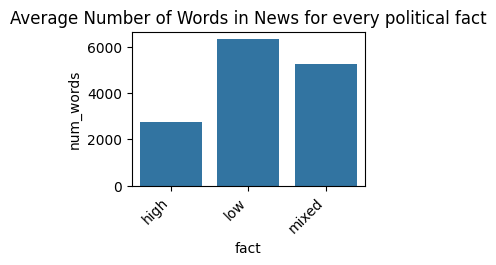

C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


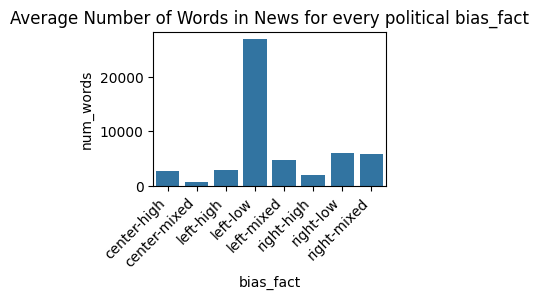

In [8]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].mean().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Average Number of Words in News for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()



C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


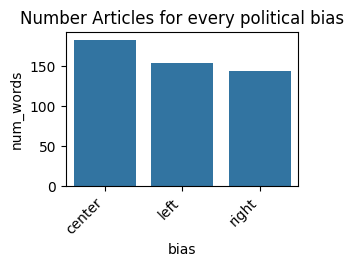

C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


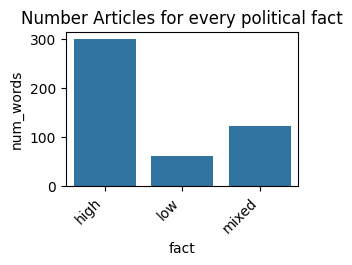

C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


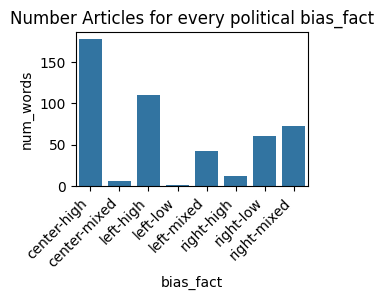

In [9]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS).count().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Number Articles for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


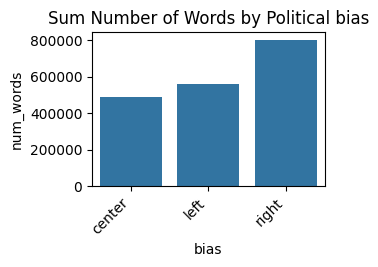

C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


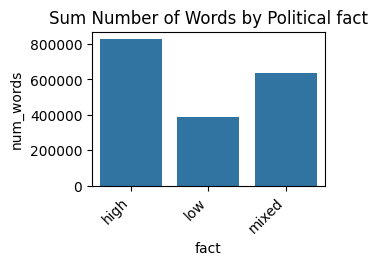

C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


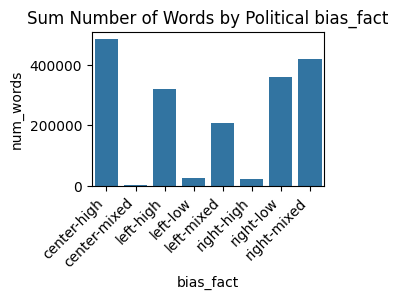

In [10]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Sum Number of Words by Political {COLUMN_FOR_ANALYSIS}')
    plt.show()


Grouping and counting the total number of words in each category.

In [11]:
sum_words = all_data.groupby('fact')['num_words'].sum()
total_words = sum_words.sum()
proportions = sum_words / total_words
print(proportions)
print('------------------------------------')
sum_words_f = all_data.groupby('bias')['num_words'].sum()
total_words_f = sum_words_f.sum()
proportions_f = sum_words_f / total_words_f
print(proportions_f)


fact
high     0.447881
low      0.208814
mixed    0.343305
Name: num_words, dtype: float64
------------------------------------
bias
center    0.264279
left      0.301401
right     0.434319
Name: num_words, dtype: float64


**It's evident that the total number of articles and words doesn't match, indicating class imbalance**

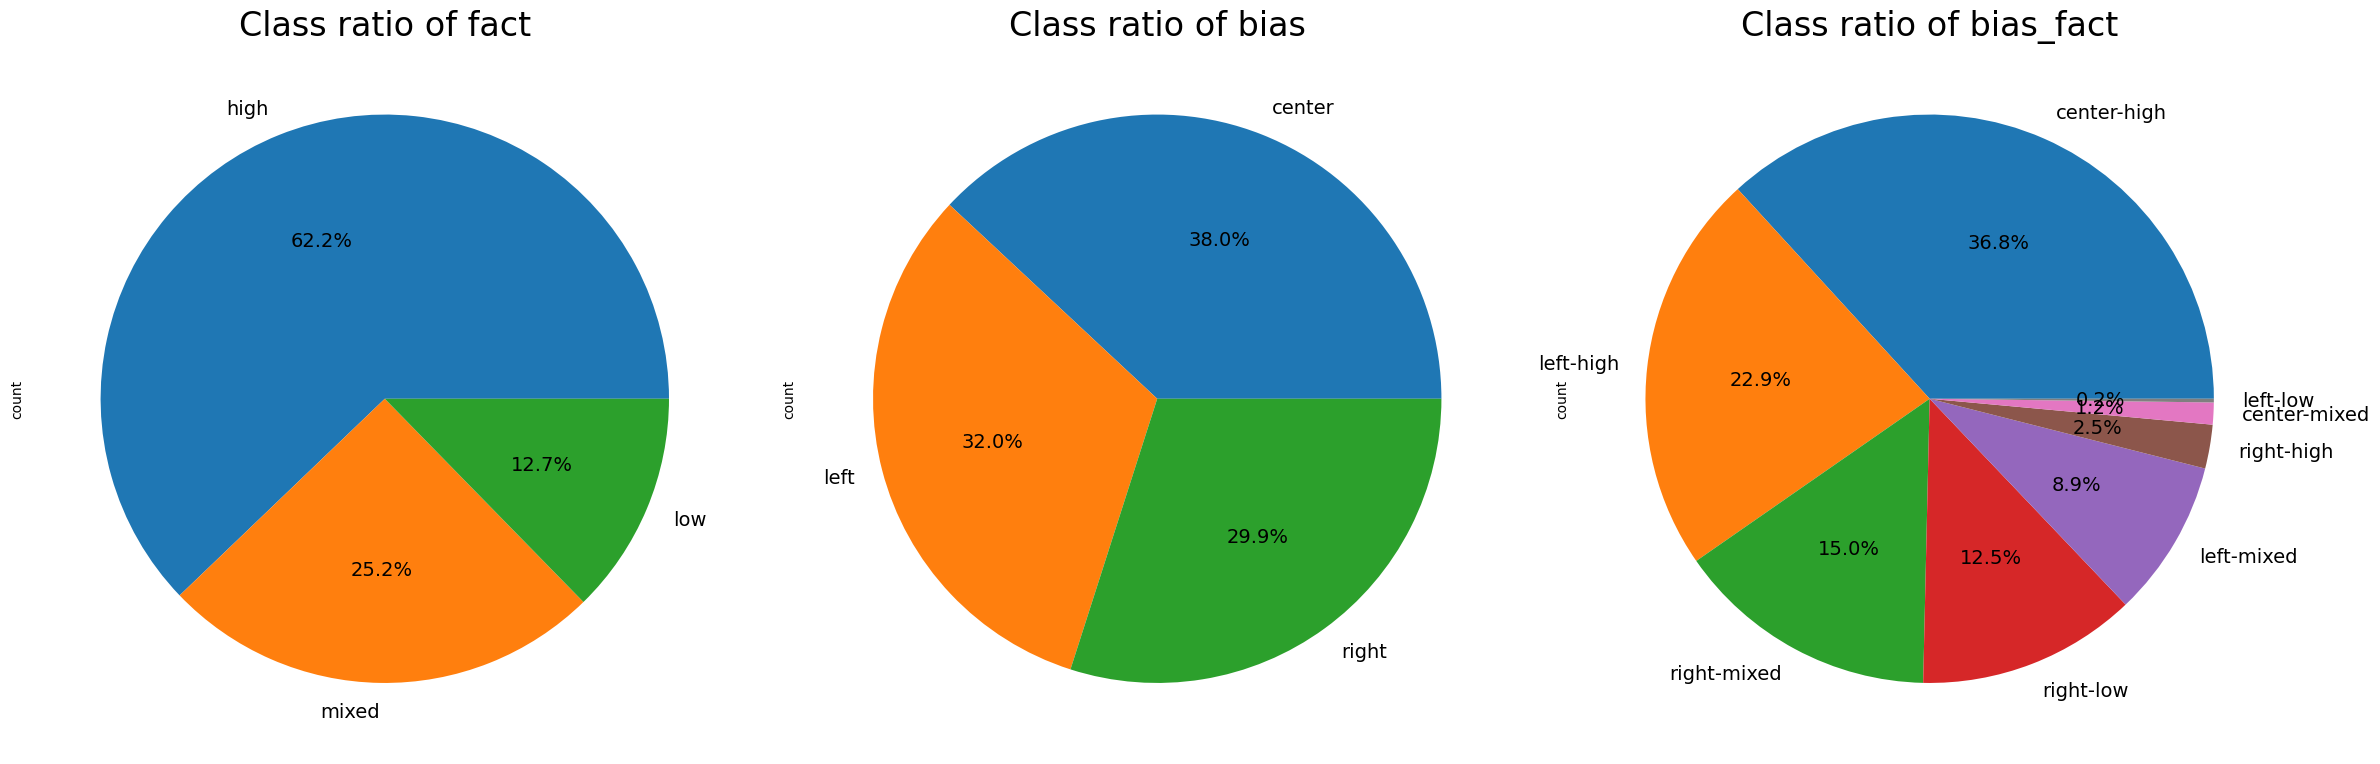

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# График 1
all_data['fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[0], textprops={'fontsize': 14}) 
ax[0].set_title('Class ratio of fact', fontsize=24)

# График 2
all_data['bias'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1], textprops={'fontsize': 14}) 
ax[1].set_title('Class ratio of bias', fontsize=24)

# График 3
all_data['bias_fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[2],  textprops={'fontsize': 14}) 
ax[2].set_title('Class ratio of bias_fact', fontsize=24)

plt.tight_layout() 
plt.show()

 **-------------------------------------------------------------------------------small data(645 newspapers)----------------------------------------------------------------------------------------------**

In [13]:
%%time
all_data = pd.DataFrame()
# json_file_name = 'wiki (481) (1).json'
json_file_name = 'wiki (2693) (2).json'
json_file_path = os.path.join(PATH, json_file_name)
df = pd.read_json(json_file_path)
# Unpacking the 'articles' column and removing it
df = df.drop('source_url', axis=1)
# Saving into one dataframe
all_data = pd.concat([all_data, df], ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'wiki']]
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

The data has been successfully loaded.
Size: (2693, 4)
CPU times: total: 391 ms
Wall time: 396 ms


Now the data represents thousands of rows where each row contains information about the article and its text.

In [14]:
print('number of newspapers:', len(all_data['name'].unique()))
print('number of wiki:', all_data.shape[0])
print('--------bias-------------------')
print(all_data['bias'].value_counts())
print('--------fact-------------------')
print(all_data['fact'].value_counts())
all_data.describe()
print('-------------------------------')


number of newspapers: 2690
number of wiki: 2693
--------bias-------------------
bias
rightcenter    779
center         750
right          477
leftcenter     403
left           284
Name: count, dtype: int64
--------fact-------------------
fact
HIGH              1392
MIXED              819
MOSTLY FACTUAL     188
LOW                165
VERY LOW            92
VERY HIGH           26
                    11
Name: count, dtype: int64
-------------------------------


In [15]:
all_data['bias_fact'] = all_data['bias'] + '-' + all_data['fact']

In [16]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact', 'bias_fact']

In [17]:
#add column with sum of words for each text
all_data['text'] = all_data['wiki'].astype(str)
all_data['num_words'] = all_data['wiki'].apply(lambda x: len(x.split() + x.split('-')))


C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


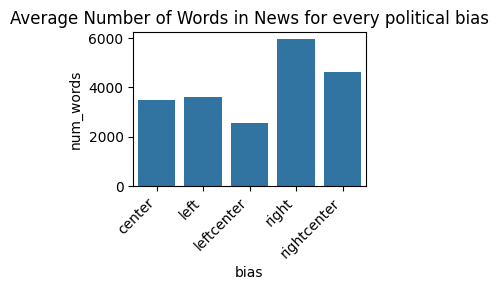

C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


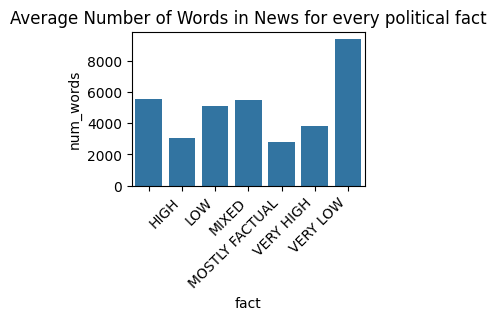

C:\Users\user\AppData\Local\Temp\ipykernel_16056\3472589650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


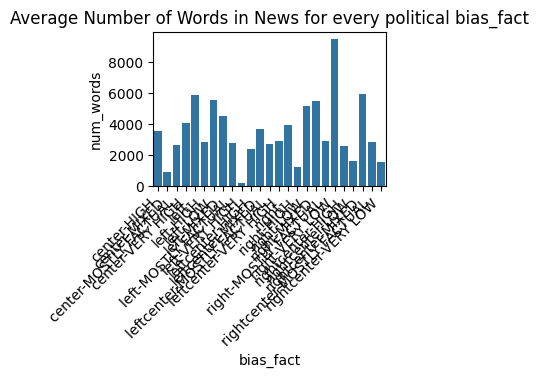

In [18]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].mean().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Average Number of Words in News for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()



C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


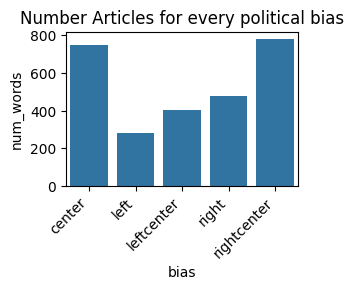

C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


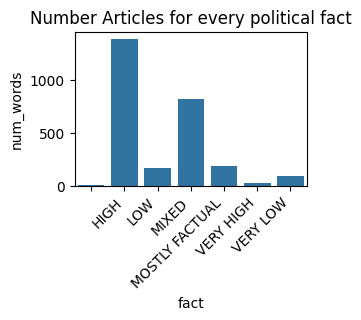

C:\Users\user\AppData\Local\Temp\ipykernel_16056\4153970442.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


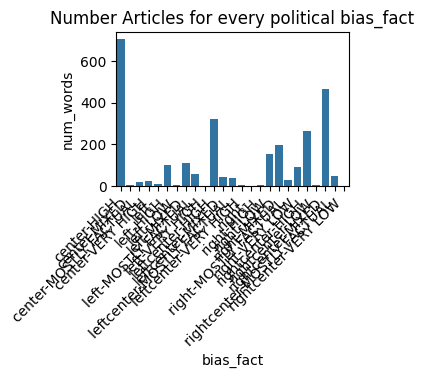

In [19]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS).count().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Number Articles for every political {COLUMN_FOR_ANALYSIS}')
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


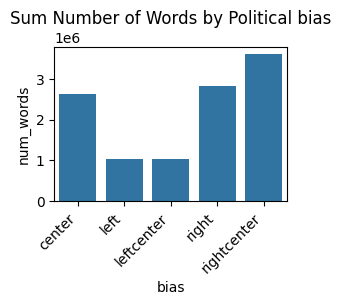

C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


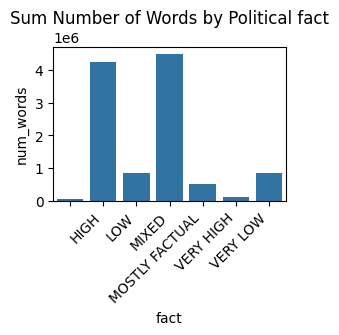

C:\Users\user\AppData\Local\Temp\ipykernel_16056\2812777158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


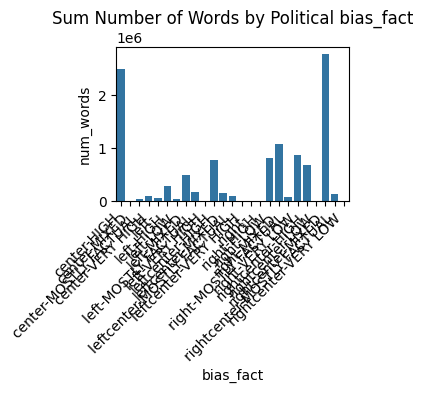

In [20]:
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Sum Number of Words by Political {COLUMN_FOR_ANALYSIS}')
    plt.show()


Grouping and counting the total number of words in each category.

In [21]:
sum_words = all_data.groupby('fact')['num_words'].sum()
total_words = sum_words.sum()
proportions = sum_words / total_words
print(proportions)
print('------------------------------------')
sum_words_f = all_data.groupby('bias')['num_words'].sum()
total_words_f = sum_words_f.sum()
proportions_f = sum_words_f / total_words_f
print(proportions_f)


fact
                  0.005484
HIGH              0.380765
LOW               0.076007
MIXED             0.404009
MOSTLY FACTUAL    0.047234
VERY HIGH         0.008881
VERY LOW          0.077619
Name: num_words, dtype: float64
------------------------------------
bias
center         0.236547
left           0.092491
leftcenter     0.092674
right          0.254766
rightcenter    0.323522
Name: num_words, dtype: float64


**It's evident that the total number of articles and words doesn't match, indicating class imbalance**

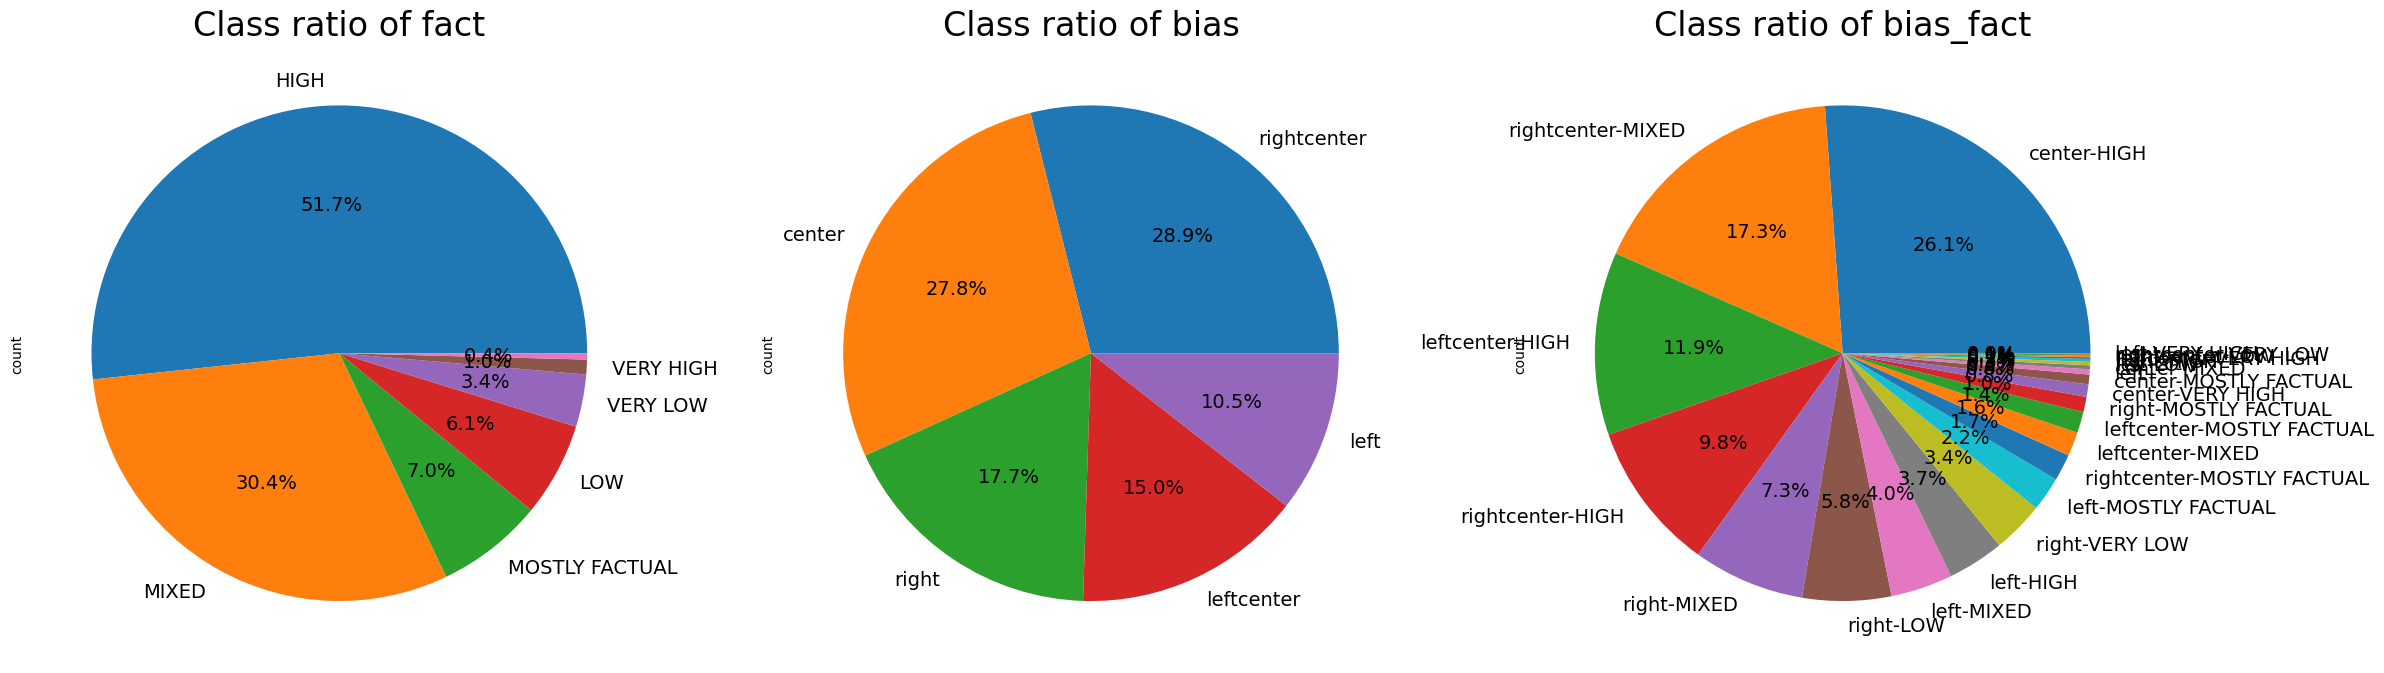

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# График 1
all_data['fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[0], textprops={'fontsize': 14}) 
ax[0].set_title('Class ratio of fact', fontsize=24)

# График 2
all_data['bias'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1], textprops={'fontsize': 14}) 
ax[1].set_title('Class ratio of bias', fontsize=24)

# График 3
all_data['bias_fact'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[2],  textprops={'fontsize': 14}) 
ax[2].set_title('Class ratio of bias_fact', fontsize=24)

plt.tight_layout() 
plt.show()